# Protein Subcellular Localization Classification
## Cell Membrane vs Nucleus - Classical & ProtVec Approaches

This notebook implements three feature extraction methods:
1. **Amino Acid Composition (AAC)** - Classical approach
2. **k-mers (tri-peptides)** - Classical approach
3. **ProtVec (Word2Vec)** - Learned model approach

**Note**: This is a faster version without ESM, using the same settings as the full notebook for reproducibility.

## 1. Setup and Data Loading

In [1]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn gensim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 33.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# For ProtVec
from gensim.models import Word2Vec

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All packages imported successfully!")

✓ All packages imported successfully!


In [3]:
# Upload the dataset file (protein_dataset.csv)
from google.colab import files
print("Please upload protein_dataset.csv:")
uploaded = files.upload()

Please upload protein_dataset.csv:


Saving protein_dataset.csv to protein_dataset.csv


In [4]:
# Load dataset
df = pd.read_csv('protein_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print("\n0 = Cell Membrane, 1 = Nucleus")

# Display first few rows
print("\nFirst few sequences:")
df.head()

Dataset shape: (2000, 2)

Class distribution:
label
0    1000
1    1000
Name: count, dtype: int64

0 = Cell Membrane, 1 = Nucleus

First few sequences:


,sequence,label
0,MLRRALLCLAVAALVRADAPEEEDHVLVLRKSNFAEALAAHKYLLV...,0
1,MRPQILLLLALLTLGLAAQHQDKVPCKMVDKKVSCQVLGLLQVPSV...,0
2,MAEERVATRTQFPVSTESQKPRQKKAPEFPILEKQNWLIHLHYIRK...,0
3,MMNFSNIMNYMKLLGQSDLPRIKTEIEALKNLRHQHICQLYHVLET...,0
4,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0


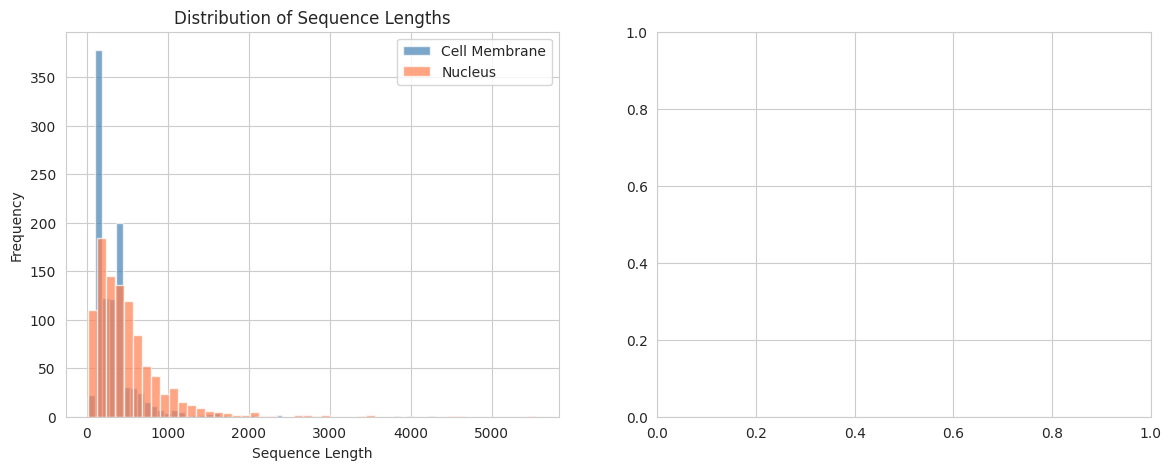

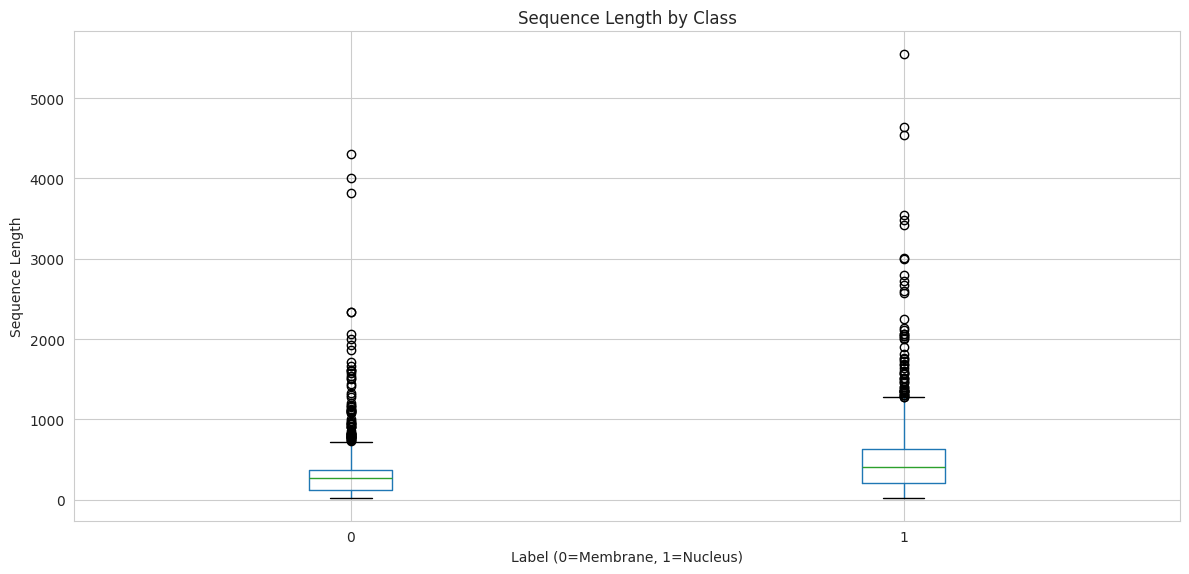


Sequence length statistics:
        count     mean         std   min    25%    50%     75%     max
label                                                                 
0      1000.0  330.873  348.662465  16.0  123.0  273.0  365.00  4303.0
1      1000.0  520.347  506.027415  20.0  208.0  406.0  636.75  5553.0


In [5]:
# Analyze sequence lengths
df['seq_length'] = df['sequence'].apply(len)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
df[df['label'] == 0]['seq_length'].hist(bins=50, alpha=0.7, label='Cell Membrane', color='steelblue')
df[df['label'] == 1]['seq_length'].hist(bins=50, alpha=0.7, label='Nucleus', color='coral')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()

plt.subplot(1, 2, 2)
df.boxplot(column='seq_length', by='label')
plt.xlabel('Label (0=Membrane, 1=Nucleus)')
plt.ylabel('Sequence Length')
plt.title('Sequence Length by Class')
plt.suptitle('')
plt.tight_layout()
plt.show()

print("\nSequence length statistics:")
print(df.groupby('label')['seq_length'].describe())

## 2. Classical Approach 1: Amino Acid Composition (AAC)

In [6]:
def amino_acid_composition(sequence):
    """
    Calculate amino acid composition (frequency of each amino acid)
    Returns a vector of 20 features (one for each standard amino acid)
    """
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    seq_length = len(sequence)

    if seq_length == 0:
        return np.zeros(20)

    composition = []
    for aa in amino_acids:
        count = sequence.count(aa)
        composition.append(count / seq_length)

    return np.array(composition)

# Extract AAC features
print("Extracting Amino Acid Composition features...")
X_aac = np.array([amino_acid_composition(seq) for seq in df['sequence']])
y = df['label'].values

print(f"✓ AAC feature shape: {X_aac.shape}")
print(f"  Feature vector example (first sequence): {X_aac[0][:5]}...")  # Show first 5 features

Extracting Amino Acid Composition features...
✓ AAC feature shape: (2000, 20)
  Feature vector example (first sequence): [0.10020877 0.01461378 0.07724426 0.11273486 0.06471816]...


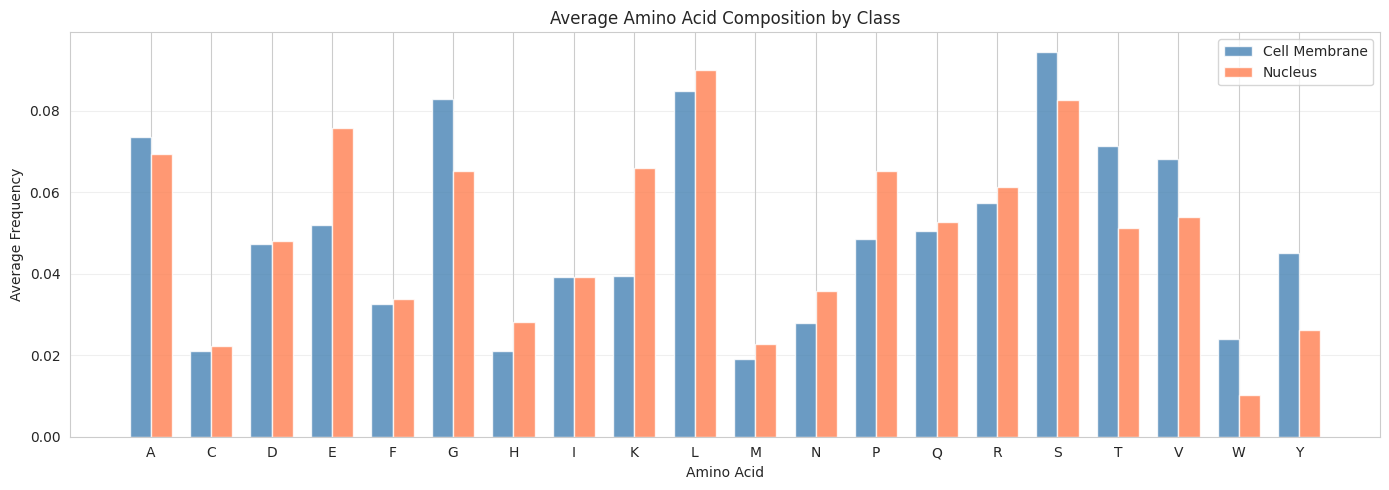


Top 5 most discriminative amino acids:
  K: 2.65% difference (enriched in Nucleus)
  E: 2.39% difference (enriched in Nucleus)
  T: 2.00% difference (enriched in Membrane)
  Y: 1.87% difference (enriched in Membrane)
  G: 1.77% difference (enriched in Membrane)


In [7]:
# Visualize AAC differences between classes
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aac_membrane = X_aac[y == 0].mean(axis=0)
aac_nucleus = X_aac[y == 1].mean(axis=0)

x = np.arange(len(amino_acids))
width = 0.35

plt.figure(figsize=(14, 5))
plt.bar(x - width/2, aac_membrane, width, label='Cell Membrane', alpha=0.8, color='steelblue')
plt.bar(x + width/2, aac_nucleus, width, label='Nucleus', alpha=0.8, color='coral')
plt.xlabel('Amino Acid')
plt.ylabel('Average Frequency')
plt.title('Average Amino Acid Composition by Class')
plt.xticks(x, list(amino_acids))
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Show top differences
diff = aac_nucleus - aac_membrane
aa_diff = list(zip(amino_acids, diff))
aa_diff_sorted = sorted(aa_diff, key=lambda x: abs(x[1]), reverse=True)
print("\nTop 5 most discriminative amino acids:")
for aa, d in aa_diff_sorted[:5]:
    enriched = "Nucleus" if d > 0 else "Membrane"
    print(f"  {aa}: {abs(d)*100:.2f}% difference (enriched in {enriched})")

## 3. Classical Approach 2: k-mers (Tri-peptides)

In [8]:
def extract_kmers(sequence, k=3):
    """
    Extract k-mers from a sequence
    Example: "MKTLLI" with k=3 -> ["MKT", "KTL", "TLL", "LLI"]
    """
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def kmer_composition(sequence, k=3, kmer_list=None):
    """
    Calculate k-mer composition
    For k=3, there are 20^3 = 8000 possible tri-peptides
    We'll use the most common ones to reduce dimensionality
    """
    kmers = extract_kmers(sequence, k)
    kmer_counts = Counter(kmers)

    if kmer_list is None:
        return kmer_counts

    # Create feature vector based on predefined k-mer list
    total_kmers = len(kmers) if len(kmers) > 0 else 1
    features = [kmer_counts.get(kmer, 0) / total_kmers for kmer in kmer_list]
    return np.array(features)

# First, collect all k-mers to find the most common ones
print("Collecting k-mers from all sequences...")
all_kmers = Counter()
for seq in df['sequence']:
    kmers = extract_kmers(seq, k=3)
    all_kmers.update(kmers)

# Use top 500 most common k-mers to reduce dimensionality
top_kmers = [kmer for kmer, count in all_kmers.most_common(500)]
print(f"✓ Using top {len(top_kmers)} k-mers")
print(f"  Most common k-mers: {top_kmers[:10]}")

✓ Using top 500 k-mers
  Most common k-mers: ['SSS', 'LLL', 'EEE', 'PPP', 'AAA', 'QQQ', 'TLR', 'AAS', 'SSL', 'GGG']


In [ ]:
# Extract k-mer features
print("Extracting k-mer composition features...")
X_kmer = np.array([kmer_composition(seq, k=3, kmer_list=top_kmers) for seq in df['sequence']])

print(f" k-mer feature shape: {X_kmer.shape}")
print(f"  Feature vector example (first sequence): {X_kmer[0][:5]}...")  # Show first 5 features

Extracting k-mer composition features...
✓ k-mer feature shape: (2000, 500)
  Feature vector example (first sequence): [0.         0.         0.00419287 0.         0.00209644]...


## 4. Learned Model Approach: ProtVec (Word2Vec)

In [10]:
def train_protvec(sequences, k=3, vector_size=100, window=5, min_count=2):
    """
    Train ProtVec model (Word2Vec on protein k-mers)
    """
    # Convert sequences to k-mer "sentences"
    kmer_sentences = [extract_kmers(seq, k) for seq in sequences]

    # Train Word2Vec model
    model = Word2Vec(
        sentences=kmer_sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        epochs=10,
        seed=42  # For reproducibility
    )

    return model

def sequence_to_protvec(sequence, model, k=3):
    """
    Convert a sequence to ProtVec representation by averaging k-mer embeddings
    """
    kmers = extract_kmers(sequence, k)
    vectors = []

    for kmer in kmers:
        if kmer in model.wv:
            vectors.append(model.wv[kmer])

    if len(vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(vectors, axis=0)

# Train ProtVec model
print("Training ProtVec model...")
protvec_model = train_protvec(df['sequence'].values, k=3, vector_size=100, window=5, min_count=2)
print(f"✓ ProtVec model trained with {len(protvec_model.wv)} k-mer embeddings")

Training ProtVec model...
✓ ProtVec model trained with 7996 k-mer embeddings


In [11]:
# Extract ProtVec features
print("Extracting ProtVec features...")
X_protvec = np.array([sequence_to_protvec(seq, protvec_model, k=3) for seq in df['sequence']])

print(f"  ProtVec feature shape: {X_protvec.shape}")
print(f"  Feature vector example (first sequence): {X_protvec[0][:5]}...")  # Show first 5 features

Extracting ProtVec features...
✓ ProtVec feature shape: (2000, 100)
  Feature vector example (first sequence): [ 0.35680377  0.05094577 -0.07478384 -0.1895177   0.16944258]...


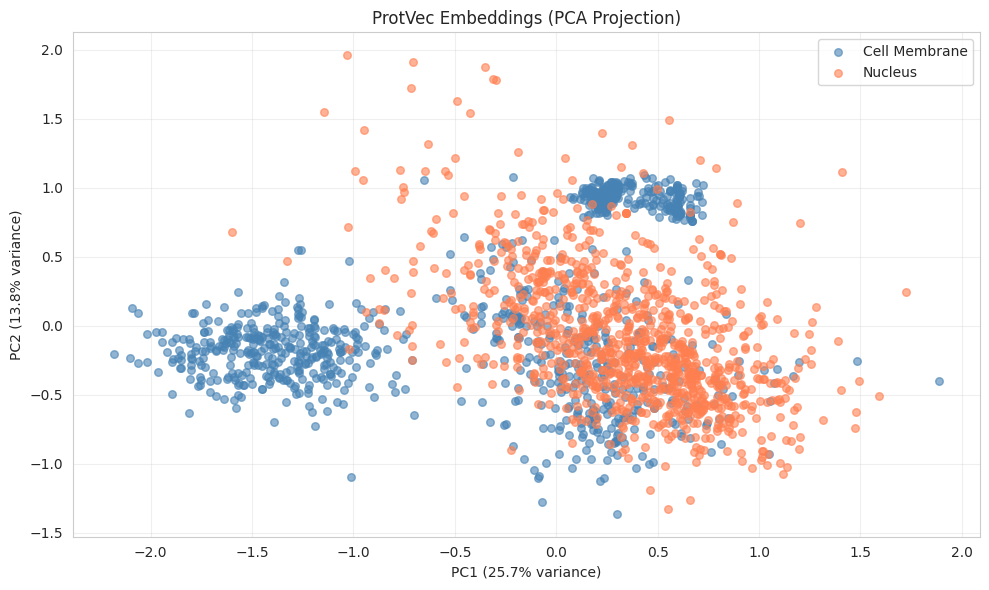

In [12]:
# Visualize ProtVec embeddings using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_protvec_2d = pca.fit_transform(X_protvec)

plt.figure(figsize=(10, 6))
plt.scatter(X_protvec_2d[y == 0, 0], X_protvec_2d[y == 0, 1],
            alpha=0.6, label='Cell Membrane', c='steelblue', s=30)
plt.scatter(X_protvec_2d[y == 1, 0], X_protvec_2d[y == 1, 1],
            alpha=0.6, label='Nucleus', c='coral', s=30)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('ProtVec Embeddings (PCA Projection)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Train and Evaluate Classifiers

In [ ]:
def evaluate_classifier(X, y, classifier, classifier_name, feature_name):
    """
    Train and evaluate a classifier using cross-validation and test set
    Uses the same settings as the full notebook for reproducibility:
    - test_size=0.2
    - random_state=42
    - stratify=y
    """
    # Split data (SAME SETTINGS AS ORIGINAL)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train classifier
    classifier.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = classifier.predict(X_test_scaled)
    y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation score (5-fold, same as original)
    cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=5)

    results = {
        'Feature': feature_name,
        'Classifier': classifier_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    }

    return results, y_test, y_pred, y_pred_proba, classifier

# Define classifiers (SAME AS ORIGINAL)
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

print("  Evaluation function and classifiers defined")
print(f"  Classifiers: {list(classifiers.keys())}")

✓ Evaluation function and classifiers defined
  Classifiers: ['Logistic Regression', 'Random Forest', 'SVM']


In [ ]:
# Evaluate all combinations
all_results = []
detailed_results = {}

feature_sets = {
    'AAC': X_aac,
    'k-mer': X_kmer,
    'ProtVec': X_protvec
}

print("Training and evaluating classifiers...\n")
print("="*70)

for feature_name, X_features in feature_sets.items():
    print(f"\n{'='*70}")
    print(f"Feature: {feature_name} (Shape: {X_features.shape})")
    print(f"{'='*70}")

    for clf_name, clf in classifiers.items():
        print(f"\n  Training {clf_name}...", end=' ')
        results, y_test, y_pred, y_pred_proba, trained_clf = evaluate_classifier(
            X_features, y, clf, clf_name, feature_name
        )

        all_results.append(results)
        detailed_results[f"{feature_name}_{clf_name}"] = {
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'model': trained_clf
        }

        print(f" F1-Score: {results['F1-Score']:.4f}, AUC: {results['AUC']:.4f}")

print(f"\n{'='*70}")
print(" All models trained successfully!")
print(f"  Total models: {len(all_results)}")

Training and evaluating classifiers...


Feature: AAC (Shape: (2000, 20))

  Training Logistic Regression... ✓ F1-Score: 0.8558, AUC: 0.9291

  Training Random Forest... ✓ F1-Score: 0.8842, AUC: 0.9328

  Training SVM... ✓ F1-Score: 0.8905, AUC: 0.9332

Feature: k-mer (Shape: (2000, 500))

  Training Logistic Regression... ✓ F1-Score: 0.8471, AUC: 0.9114

  Training Random Forest... ✓ F1-Score: 0.8761, AUC: 0.9240

  Training SVM... ✓ F1-Score: 0.8764, AUC: 0.9373

Feature: ProtVec (Shape: (2000, 100))

  Training Logistic Regression... ✓ F1-Score: 0.8954, AUC: 0.9370

  Training Random Forest... ✓ F1-Score: 0.8789, AUC: 0.9385

  Training SVM... ✓ F1-Score: 0.8884, AUC: 0.9345

✓ All models trained successfully!
  Total models: 9


## 6. Results Summary

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)

print("\n" + "="*90)
print("CLASSIFICATION RESULTS SUMMARY")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

# Find best model
best_idx = results_df['F1-Score'].idxmax()
best_model = results_df.iloc[best_idx]
print(f"\n BEST MODEL:")
print(f"   Feature: {best_model['Feature']}")
print(f"   Classifier: {best_model['Classifier']}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   AUC: {best_model['AUC']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")


CLASSIFICATION RESULTS SUMMARY
Feature          Classifier  Accuracy  Precision  Recall  F1-Score    AUC  CV Mean  CV Std
    AAC Logistic Regression    0.8500     0.8241   0.890    0.8558 0.9291   0.8681  0.0091
    AAC       Random Forest    0.8775     0.8386   0.935    0.8842 0.9328   0.8956  0.0175
    AAC                 SVM    0.8850     0.8500   0.935    0.8905 0.9332   0.8988  0.0073
  k-mer Logistic Regression    0.8475     0.8492   0.845    0.8471 0.9114   0.8331  0.0123
  k-mer       Random Forest    0.8600     0.7857   0.990    0.8761 0.9240   0.8663  0.0111
  k-mer                 SVM    0.8625     0.7959   0.975    0.8764 0.9373   0.8856  0.0155
ProtVec Logistic Regression    0.8925     0.8720   0.920    0.8954 0.9370   0.8744  0.0116
ProtVec       Random Forest    0.8725     0.8371   0.925    0.8789 0.9385   0.8975  0.0189
ProtVec                 SVM    0.8825     0.8462   0.935    0.8884 0.9344   0.9000  0.0120

🏆 BEST MODEL:
   Feature: ProtVec
   Classifier: Logistic